In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [4]:
import os
import pickle
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [6]:
# /avsavchenko/src/emotions-multimodal/faces/ABAW/abaw5/enet_b0_8_best_vgaf_cropped.pickle

In [7]:
# with open('fea_notebooks/features_newvf.pickle', 'rb') as handle:
#     data=pickle.load(handle)
# print(len(data))

In [8]:
with open('/home/avsavchenko/src/emotions-multimodal/faces/ABAW/abaw5/enet_b0_8_best_vgaf_cropped.pickle', 'rb') as handle:
    data=pickle.load(handle)
print(len(data))

2942996


In [ ]:
# with open('home/avsavchenko/src/emotions-multimodal/faces/ABAW/abaw5/expr_enet0_vgaf.h5', 'rb') as handle:
#     model=pickle.load(handle)
# model

In [5]:
# with open('fea_notebooks/features_newvf.pickle', 'rb') as handle:
#     data=pickle.load(handle)
# print(len(data))

2941546


In [9]:
print(f"Torch: {torch.__version__}")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

Torch: 2.0.1+cu118
cuda:0


In [10]:
results = pd.DataFrame(columns=['f1-score val'])

# EXPR_Recognition_Challenge

In [10]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('expr-only video')
experiment.add_tags(['expr_classif - only video', 'v1_linear'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/eba0fc5afba84c59b1520219178b2dc8



In [11]:
idx_to_class_2={0: 'Neutral', 1:'Anger', 2:'Disgust', 3:'Fear', 
                4:'Happiness', 5:'Sadness', 6:'Surprise', 7:'Other'} #ABAW
classes = ['Neutral', 'Anger', 'Disgust', 'Fear', 
           'Happiness', 'Sadness', 'Surprise', 'Other']

In [12]:
# DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations'
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_5/VA_AU_FER'

def get_image2Expr(dirname):
#     dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/',dirname)
    dirpath=os.path.join(DATA_DIR,'EXPR_Classification_Challenge/',dirname)
    num_missed=[]
    targets = {}
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                prev_val=None
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            imagename=fn+'/'+str(i).zfill(5)+'.jpg'
                            if imagename in data:
                                targets[imagename] = expression
                            else:
                                num_missed.append(imagename)
    print(len(targets), len(num_missed))
    return targets, num_missed

y_train, num_missed_train = get_image2Expr('Train_Set')
y_val, num_missed_test =get_image2Expr('Validation_Set')

585317 12044
280532 3698


## Simple video

In [13]:
X_train, y_t = [], []
for key in y_train.keys():
#     X_train.append(data[key]['frame'][0])
    X_train.append(data[key][0])
    y_t.append(y_train[key])

X_val, y_v = [], []
for key in y_val.keys():
#     X_val.append(data[key]['frame'][0])
    X_val.append(data[key][0])
    y_v.append(y_val[key])
    
len(X_train), len(X_val), len(y_t), len(y_v)

(585317, 280532, 585317, 280532)

### keras

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
import efficientnet.tfkeras as enet
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.13.1


In [15]:
(unique, counts) = np.unique(y_t, return_counts=True)
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print()
print(np.unique(y_v, return_counts=True))

[177198  16573  10771   9080  95463  78751  31615 165866] {0: 1.0, 1: 10.691968865021419, 2: 16.451397270448425, 3: 19.515198237885464, 4: 1.856195594104522, 5: 2.2501047605744686, 6: 5.6048711054879, 7: 1.0683202102902343} 8 [0 1 2 3 4 5 6 7]

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 82258,   6126,   5296,   8408,  34511,  25157,  12332, 106444]))


In [16]:
X_train[0]

array([-0.11533788, -0.10590152, -0.17468455, ..., -0.07262666,
        0.01172303, -0.01389069], dtype=float32)

In [17]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [18]:
batch_size=256 #128
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(num_classes, input_shape=X_train.shape[1:],activation='softmax',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_train.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(num_classes,activation='softmax'))

In [19]:
y_t, y_v = np.array(y_t), np.array(y_v)

In [20]:
mlpModel.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlpModel.summary()

# save_best_model = SaveBestModel('val_accuracy',True)
mlpModel.fit(X_train,y_t, batch_size=batch_size, epochs=1 if True else 10, verbose=1, validation_data=(X_val,y_v),class_weight=class_weights)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 165000 (644.53 KB)
Trainable params: 165000 (644.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2287/2287 [==============================] - 21s 8ms/step - loss: 1.0513 - accuracy: 0.8293 - val_loss: 1.9463 - val_accuracy: 0.4672


In [21]:
def print_expr():
    y_val_preds=mlpModel.predict(X_val)
    y_pred=np.argmax(y_val_preds,axis=1)
    print('F1:',f1_score(y_true=y_v,y_pred=y_pred, average="macro"))

In [22]:
print_expr()

8767/8767 [==============================] - 23s 3ms/step
F1: 0.3373286558762978


## Simple video

In [23]:
# import gc

# gc.collect()
# del data
# gc.collect()

In [24]:
# X_train_c=np.concatenate((X_train,X_val))
# y_train_c=np.concatenate((y_t,y_v))
# print(X_train_c.shape,y_train_c.shape)

In [25]:
(unique, counts) = np.unique(y_t, return_counts=True)
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print()
print(np.unique(y_v, return_counts=True))

[177198  16573  10771   9080  95463  78751  31615 165866] {0: 1.0, 1: 10.691968865021419, 2: 16.451397270448425, 3: 19.515198237885464, 4: 1.856195594104522, 5: 2.2501047605744686, 6: 5.6048711054879, 7: 1.0683202102902343} 8 [0 1 2 3 4 5 6 7]

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 82258,   6126,   5296,   8408,  34511,  25157,  12332, 106444]))


In [26]:
class onlyVideo(nn.Module):
    def __init__(self, input_size, classes):
        super(onlyVideo, self).__init__()

        self.linear1 = nn.Linear(input_size, 256)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(256, classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x
    
model = onlyVideo(X_train[0].shape[0], num_classes)
model.to(device)

onlyVideo(
  (linear1): Linear(in_features=1280, out_features=256, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=256, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [28]:
hyperparams = {
    'epochs': 1,
    'loss': 'categorical_crossentropy',
    'lr': 1e-3,
    'batch': 256
}

training_loader = DataLoader(list(zip(X_train, y_t)),
                             batch_size=hyperparams['batch'], 
                             shuffle=True)
validation_loader = DataLoader(list(zip(X_val, y_v)),
                             batch_size=hyperparams['batch'], 
                             shuffle=True)

In [29]:
experiment.log_parameters(hyperparams)

loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(cw)).to(device)
optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])

best_model_params = deepcopy(model.state_dict())

best_vloss = 1e+6
# hyperparams['epochs'] = 5

for epoch in range(hyperparams['epochs']):
    print('EPOCH {}:'.format(epoch + 1))
    pred_labels_train, pred_labels_val = [], []
    labels_train, labels_val = [], []

    model.train(True)
    
    running_loss = 0.
    last_loss = 0.

    for i, tdata in enumerate(training_loader):
        inputs, labels = tdata
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        pred_labels_train += predicted.tolist()
        labels_train += labels.tolist()
    
    avg_loss = running_loss / i + 1
    experiment.log_metric('loss_train', avg_loss, 
                          epoch=epoch)
    
    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            
            _, predicted = torch.max(voutputs.data, 1)
            pred_labels_val += predicted.tolist()
            labels_val += vlabels.tolist()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}, f1_valid {}'.format(avg_loss, avg_vloss, f1_score(labels_val,
                                                                                     pred_labels_val,
                                                                                     average='macro')))
    experiment.log_metric('loss_val', avg_vloss, 
                          epoch=epoch)
    experiment.log_metric('f1_val', f1_score(labels_val,
                                             pred_labels_val,
                                             average='macro'), 
                          epoch=epoch)
    experiment.log_metric('f1_train', f1_score(labels_train,
                                               pred_labels_train,
                                               average='macro'), 
                          epoch=epoch)
    
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model_params = deepcopy(model.state_dict())

EPOCH 1:
LOSS train 2.4710752283494304 valid 1.9386351108551025, f1_valid 0.3263215214175432


In [30]:
(np.array(labels_val)==np.array(pred_labels_val)).mean()

0.4575271270300714

In [ ]:
model.load_state_dict(best_model_params)
pred_labels_val, labels_val = [], []

model.eval()
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)

        _, predicted = torch.max(voutputs.data, 1)
        pred_labels_val += predicted.tolist()
        labels_val += vlabels.tolist()
        
f1 = f1_score(labels_val,
        pred_labels_val,
        average='macro')

In [21]:
results.loc['only video',: ] = f1

In [22]:
experiment.log_confusion_matrix(
    np.array(labels_val),np.array(pred_labels_val),
    title="Confusion Matrix: Evaluation",
    file_name="confusion-matrix-eval.json",
)

{'web': 'https://www.comet.com/api/asset/download?assetId=d052b7eaffe14c1d890c9fb4e88a9b53&experimentKey=58107321df414c69a15bc7f3771cc77f',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d052b7eaffe14c1d890c9fb4e88a9b53&experimentKey=58107321df414c69a15bc7f3771cc77f',
 'assetId': 'd052b7eaffe14c1d890c9fb4e88a9b53'}

(279749,) (279749,) 0.9223875688563676


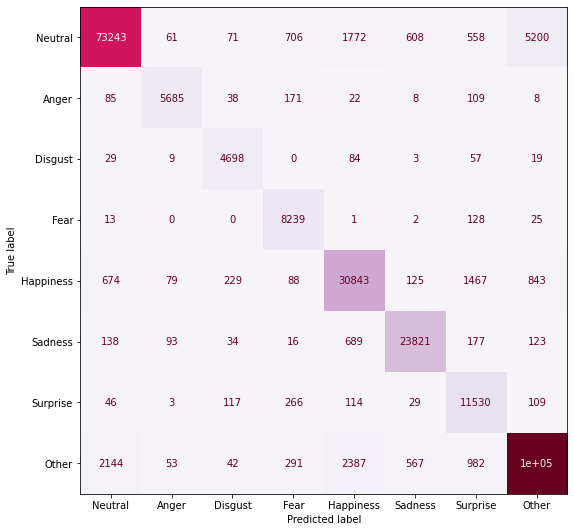

In [23]:
labels=classes
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='PuRd', colorbar=False)
    plt.tight_layout()
    plt.show()

plt_conf_matrix(np.array(labels_val),np.array(pred_labels_val),labels);

In [20]:
torch.save(model.state_dict(), 'simplemodel.pt')

In [21]:
experiment.log_model("simplemodel.pt", file_or_folder="simplemodel.pt")

{'web': 'https://www.comet.com/api/asset/download?assetId=11f0cc0c2e784f7e8947994cb3fb0003&experimentKey=cd9e2b15caf343f394ea0aa28c795d0d',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=11f0cc0c2e784f7e8947994cb3fb0003&experimentKey=cd9e2b15caf343f394ea0aa28c795d0d',
 'assetId': '11f0cc0c2e784f7e8947994cb3fb0003'}

In [24]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/58107321df414c69a15bc7f3771cc77f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     f1_train [10]   : (0.7045167530968035, 0.9057479942505359)
COMET INFO:     f1_val [10]     : (0.7906992371998944, 0.9136834740158497)
COMET INFO:     loss [3386]     : (1.2977038621902466, 2.0802061557769775)
COMET INFO:     loss_train [10] : (2.3408527805674906, 2.4847490593460853)
COMET INFO:     loss_val [10]   : (1.3363474607467651, 1.414238452911377)
COMET INFO:   Others:
COMET INFO:     Name : expr-only video
COMET INFO:   Parameters:
COMET INFO:     batch  : 256
COMET INFO:     epochs : 10
COMET INFO:     loss   : spar

## openl3

In [10]:
def train_val_split(feature, y_train, y_val):
    X_train, op_train, y_t = [], [], []
    for key in y_train.keys():
        X_train.append(data[key]['frame'][0])
        op_train.append(data[key][feature])
        y_t.append(y_train[key])

    X_val, op_val, y_v = [], [], []
    for key in y_val.keys():
        X_val.append(data[key]['frame'][0])
        op_val.append(data[key][feature])
        y_v.append(y_val[key])

    print(len(X_train), len(op_train), 
          len(y_t), len(X_val), 
          len(op_val), len(y_v))
    
    return (X_train, op_train, 
            y_t, X_val, 
            op_val, y_v)

def train(cw, hyperparams, model, training_loader, validation_loader):

    loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(cw)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])

    best_model_params = deepcopy(model.state_dict())

    best_vloss = 1e+6

    for epoch in range(hyperparams['epochs']):
        print('EPOCH {}:'.format(epoch + 1))
        pred_labels_train, pred_labels_val = [], []
        labels_train, labels_val = [], []

        model.train(True)

        running_loss = 0.
        last_loss = 0.

        for i, tdata in enumerate(training_loader):
            inputs, inputsa, labels = tdata
            inputs, inputsa, labels = inputs.to(device), inputsa.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputsa, inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            pred_labels_train += predicted.tolist()
            labels_train += labels.tolist()

        avg_loss = running_loss / i + 1
        experiment.log_metric('loss_train', avg_loss, 
                              epoch=epoch)

        running_vloss = 0.0
        model.eval()
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vainput, vlabels = vdata
                vinputs, vainput, vlabels = vinputs.to(device), vainput.to(device), vlabels.to(device)
                voutputs = model(vainput, vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss

                _, predicted = torch.max(voutputs.data, 1)
                pred_labels_val += predicted.tolist()
                labels_val += vlabels.tolist()

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}, f1_valid {}'.format(avg_loss, avg_vloss, f1_score(labels_val,
                                                                                     pred_labels_val,
                                                                                     average='macro')))
        experiment.log_metric('loss_val', avg_vloss, 
                              epoch=epoch)
        experiment.log_metric('f1_val', f1_score(labels_val,
                                                 pred_labels_val,
                                                 average='macro'), 
                              epoch=epoch)
        experiment.log_metric('f1_train', f1_score(labels_train,
                                                   pred_labels_train,
                                                   average='macro'), 
                              epoch=epoch)

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_model_params = deepcopy(model.state_dict())
            
    return best_model_params

def exp_with1fea(experiment, feature, y_train, y_val, hyperparams, Model, shapes, cw, classes, result):
    X_train, op_train,\
    y_t, X_val,\
    op_val, y_v = train_val_split(feature, y_train, y_val)
    print(op_val[0].shape)

    training_loader = DataLoader(list(zip(X_train, 
                                          op_train,
                                          y_t)),
                                 batch_size=hyperparams['batch'], 
                                 shuffle=True)
    validation_loader = DataLoader(list(zip(X_val, 
                                            op_val,
                                            y_v)),
                                 batch_size=hyperparams['batch'], 
                                 shuffle=True)
    
    experiment.log_parameters(hyperparams)
    
    model = Model(X_train[0].shape[0], op_val[0].shape[0], *shapes)
    model.to(device)
    best_model_params = train(cw, hyperparams, model, training_loader, validation_loader)
    
    model.load_state_dict(best_model_params)
    pred_labels_val, labels_val = [], []

    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vainput, vlabels = vdata
            vinputs, vainput, vlabels = vinputs.to(device), vainput.to(device), vlabels.to(device)
            voutputs = model(vainput, vinputs)

            _, predicted = torch.max(voutputs.data, 1)
            pred_labels_val += predicted.tolist()
            labels_val += vlabels.tolist()

    print('f1-score: ', f1_score(labels_val,
            pred_labels_val,
            average='macro'))
    results.loc['video'+feature,: ] = [f1_score(labels_val,
                                            pred_labels_val,
                                            average='macro')]
    
    experiment.log_confusion_matrix(
    np.array(labels_val),np.array(pred_labels_val),
    title="Confusion Matrix: Evaluation",
    file_name="confusion-matrix-eval.json",
    )
    
    labels=classes
    IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})

    plt_conf_matrix(np.array(labels_val),np.array(pred_labels_val),labels);
    
    torch.save(model.state_dict(), 'simplemodel.pt')
    
    experiment.log_model("simplemodel.pt", file_or_folder="simplemodel.pt")
    experiment.end()

In [11]:
hyperparams = {
    'epochs': 10,
    'loss': 'sparse_categorical_crossentropy',
    'lr': 1e-3,
    'batch': 256
}

class Model(nn.Module):
    def __init__(self, input_size_vi, input_size_op,
                 out_vi, out_a1, out_a2,
                 classes):
        super(Model, self).__init__()

        self.linear1 = nn.Linear(input_size_vi, out_vi)
        self.activation = nn.ReLU()
        
        self.linear2 = nn.Linear(input_size_op, out_a1)
        self.activation2 = nn.ReLU()
        
        self.linear3 = nn.Linear(out_a1, out_a2)
        self.activation3 = nn.ReLU()
        
        self.linear4 = nn.Linear(out_vi+out_a2, classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, op, vi):
        vi = self.linear1(vi)
        vi = self.activation(vi)
        
        op = self.linear2(op)
        op = self.activation2(op)
        
        op = self.linear3(op)
        op = self.activation3(op)
        
#         print(op.shape, vi.shape)
        
        x = torch.cat((op, vi), 1)
#         print(x.shape)
        
        x = self.linear4(x)
        x = self.softmax(x)
        return x

In [25]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('openl3+vid-expr')
experiment.add_tags(['expr_classif - openl3 + video', 'v1_linear'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/b043054608fe4e9cb1ea0ba58d93445b



586959 586959 586959 279749 279749 279749
(512,)
EPOCH 1:
LOSS train 2.4852993458665478 valid 1.9554595947265625, f1_valid 0.3185353320225631
EPOCH 2:
LOSS train 2.400891345052819 valid 1.9597707986831665, f1_valid 0.3144024942553613
EPOCH 3:
LOSS train 2.3770483169464125 valid 1.9688801765441895, f1_valid 0.3050921527072701
EPOCH 4:
LOSS train 2.363590903203109 valid 1.980920433998108, f1_valid 0.2784534247872661
EPOCH 5:
LOSS train 2.353713943956202 valid 1.9671821594238281, f1_valid 0.30853054176350203
EPOCH 6:
LOSS train 2.347180513551306 valid 1.9694629907608032, f1_valid 0.3093183547162289
EPOCH 7:
LOSS train 2.341631431282087 valid 1.971526026725769, f1_valid 0.2992060871462512
EPOCH 8:
LOSS train 2.337242380070645 valid 1.9794929027557373, f1_valid 0.29216071040906566
EPOCH 9:
LOSS train 2.334402851825401 valid 1.9789444208145142, f1_valid 0.2981431488556294
EPOCH 10:
LOSS train 2.3310093750712344 valid 1.980272889137268, f1_valid 0.29931365744274596
f1-score:  0.31853533202256

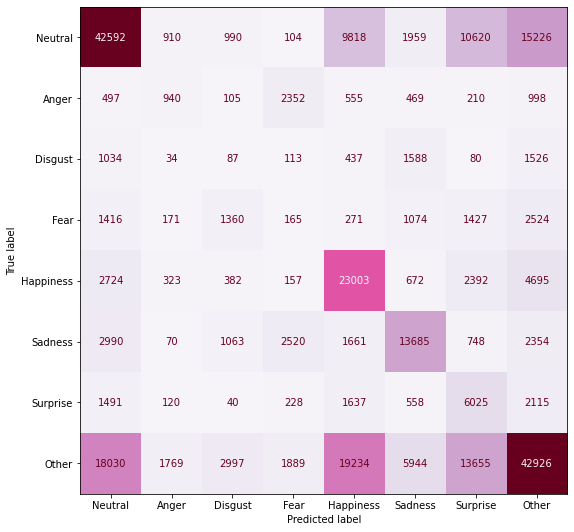

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/b043054608fe4e9cb1ea0ba58d93445b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     f1_train [10]   : (0.7017568475690339, 0.9162915302587432)
COMET INFO:     f1_val [10]     : (0.2784534247872661, 0.3185353320225631)
COMET INFO:     loss [2293]     : (1.291216254234314, 2.0787782669067383)
COMET INFO:     loss_train [10] : (2.3310093750712344, 2.4852993458665478)
COMET INFO:     loss_val [10]   : (1.9554595947265625, 1.980920433998108)
COMET INFO:   Others:
COMET INFO:     Name : openl3+vid-expr
COMET INFO:   Parameters:
COMET INFO:     batch  : 256
COMET INFO:     epochs : 10
COMET INFO:     loss   : spars

In [26]:
shapes = [128, 256, 128, 8]
exp_with1fea(experiment, 'openl3', y_train, y_val, hyperparams, Model, shapes, cw, classes, results)

## wav2vec2 hubert

In [27]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('w2v2hub+vid-expr')
experiment.add_tags(['expr_classif - w2v2hub + video', 'v1_linear'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/ebe39bb6befc47418763ec797a25be4e



586959 586959 586959 279749 279749 279749
(256,)
EPOCH 1:
LOSS train 2.4772481446594883 valid 1.944740891456604, f1_valid 0.3260925004355182
EPOCH 2:
LOSS train 2.3975902840521117 valid 1.961737871170044, f1_valid 0.31493775557384335
EPOCH 3:
LOSS train 2.3740492477154858 valid 1.9517005681991577, f1_valid 0.32659283545467027
EPOCH 4:
LOSS train 2.3610149828447304 valid 1.9518071413040161, f1_valid 0.32808844849196916
EPOCH 5:
LOSS train 2.3524511276011273 valid 1.9618000984191895, f1_valid 0.32387099075037834
EPOCH 6:
LOSS train 2.3465882201157315 valid 1.961350679397583, f1_valid 0.32045309412230705
EPOCH 7:
LOSS train 2.3406677896751784 valid 1.9701839685440063, f1_valid 0.3107093933590095
EPOCH 8:
LOSS train 2.335797028287751 valid 1.970298171043396, f1_valid 0.3047611122526682
EPOCH 9:
LOSS train 2.3318109421829902 valid 1.9724494218826294, f1_valid 0.3044633106044164
EPOCH 10:
LOSS train 2.329049341809687 valid 1.9710334539413452, f1_valid 0.3147145665611506
f1-score:  0.32609250

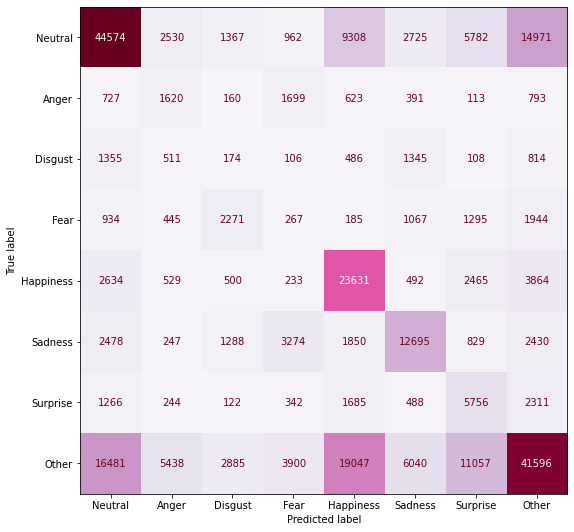

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/ebe39bb6befc47418763ec797a25be4e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     f1_train [10]   : (0.7152281897312416, 0.921819578623902)
COMET INFO:     f1_val [10]     : (0.3044633106044164, 0.32808844849196916)
COMET INFO:     loss [2293]     : (1.2884403467178345, 2.0805962085723877)
COMET INFO:     loss_train [10] : (2.329049341809687, 2.4772481446594883)
COMET INFO:     loss_val [10]   : (1.944740891456604, 1.9724494218826294)
COMET INFO:   Others:
COMET INFO:     Name : w2v2hub+vid-expr
COMET INFO:   Parameters:
COMET INFO:     batch  : 256
COMET INFO:     epochs : 10
COMET INFO:     loss   : spar

In [30]:
shapes = [128, 128, 64, 8]
exp_with1fea(experiment, 'w2v2hub', y_train, y_val, hyperparams, Model, shapes, cw, classes, results)

## w2v2large

In [31]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('w2v2large+vid-expr')
experiment.add_tags(['expr_classif - w2v2large + video', 'v1_linear'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/62c671c780c648b480ae3b4dd504fc82



586959 586959 586959 279749 279749 279749
(1024,)
EPOCH 1:
LOSS train 2.458171666448653 valid 1.945655345916748, f1_valid 0.32629643323604873
EPOCH 2:
LOSS train 2.362272559452223 valid 1.947769284248352, f1_valid 0.33004804332939824
EPOCH 3:
LOSS train 2.3346425090992846 valid 1.953153371810913, f1_valid 0.33175862791600536
EPOCH 4:
LOSS train 2.3222724296035566 valid 1.970698595046997, f1_valid 0.3158537768721841
EPOCH 5:
LOSS train 2.316037582737405 valid 1.9551305770874023, f1_valid 0.328649945992069
EPOCH 6:
LOSS train 2.3117949162166154 valid 1.9635372161865234, f1_valid 0.3256833928252393
EPOCH 7:
LOSS train 2.308930201420193 valid 1.9805065393447876, f1_valid 0.30075823187944356
EPOCH 8:
LOSS train 2.306477706261746 valid 1.9845693111419678, f1_valid 0.3051043923490591
EPOCH 9:
LOSS train 2.3047615309972413 valid 1.9756851196289062, f1_valid 0.3035406876700429
EPOCH 10:
LOSS train 2.303820965853869 valid 1.9841386079788208, f1_valid 0.30043665093263366
f1-score:  0.326296433236

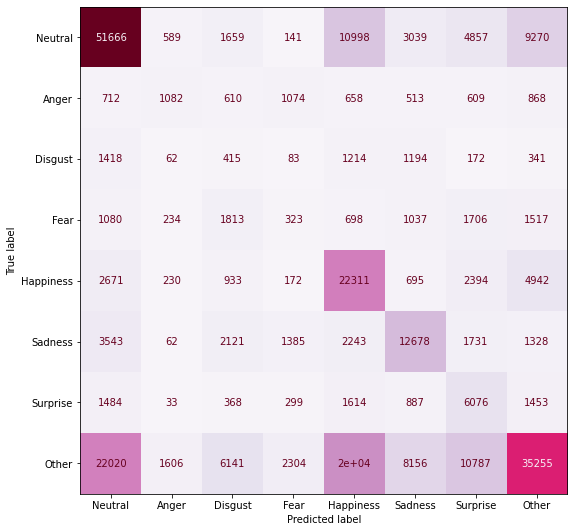

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/62c671c780c648b480ae3b4dd504fc82
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     f1_train [10]   : (0.7375876140622799, 0.9606367793310477)
COMET INFO:     f1_val [10]     : (0.30043665093263366, 0.33175862791600536)
COMET INFO:     loss [2293]     : (1.2751814126968384, 2.0792348384857178)
COMET INFO:     loss_train [10] : (2.303820965853869, 2.458171666448653)
COMET INFO:     loss_val [10]   : (1.945655345916748, 1.9845693111419678)
COMET INFO:   Others:
COMET INFO:     Name : w2v2large+vid-expr
COMET INFO:   Parameters:
COMET INFO:     batch  : 256
COMET INFO:     epochs : 10
COMET INFO:     loss   : s

In [33]:
shapes = [128, 512, 128, 8]
exp_with1fea(experiment, 'w2v2large', y_train, y_val, hyperparams, Model, shapes, cw, classes, results)

In [36]:
results

,f1-score val
only video,0.319133
videoopenl3,0.318535
videow2v2hub,0.326093
videow2v2large,0.326296
videoopensmile,0.00535724


## all data

In [37]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('all_fea-expr_classif')
experiment.add_tags(['expr_classif - all_fea', 'v1_linear'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/96889028072e483c961dcc3c9bc7e010



In [38]:
X_train, audio_train, y_t = [], [], []
for key in y_train.keys():
    X_train.append(data[key]['frame'][0])
    audio = np.concatenate([data[key]['openl3'],
                            data[key]['w2v2hub'],
                            data[key]['w2v2large']], 
                           axis=0)
    audio_train.append(audio)
    y_t.append(y_train[key])

X_val, audio_val, y_v = [], [], []
for key in y_val.keys():
    X_val.append(data[key]['frame'][0])
    audio = np.concatenate([data[key]['openl3'],
                            data[key]['w2v2hub'],
                            data[key]['w2v2large']], 
                           axis=0)
    audio_val.append(audio)
    y_v.append(y_val[key])
    
len(X_train), len(audio_train), len(y_t), len(X_val), len(audio_val), len(y_v)

(586959, 586959, 586959, 279749, 279749, 279749)

In [39]:
audio_train[0].shape[0]

1792

In [40]:
hyperparams = {
    'epochs': 10,
    'loss': 'sparse_categorical_crossentropy',
    'lr': 1e-3,
    'batch': 256
}

class allFea(nn.Module):
    def __init__(self, input_size_vi, input_size_op,
                 out_vi, out_a1, out_a2,
                 classes):
        super(allFea, self).__init__()

        self.linear1 = nn.Linear(input_size_vi, out_vi)
        self.activation = nn.ReLU()
        
        self.linear2 = nn.Linear(input_size_op, out_a1)
        self.activation2 = nn.ReLU()
        
        self.linear3 = nn.Linear(out_a1, out_a2)
        self.activation3 = nn.ReLU()
        
        self.linear4 = nn.Linear(out_vi+out_a2, classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, op, vi):
        vi = self.linear1(vi)
        vi = self.activation(vi)
        
        op = self.linear2(op)
        op = self.activation2(op)
        
        op = self.linear3(op)
        op = self.activation3(op)
        
#         print(op.shape, vi.shape)
        
        x = torch.cat((op, vi), 1)
#         print(x.shape)
        
        x = self.linear4(x)
        x = self.softmax(x)
        return x
    
model = allFea(X_train[0].shape[0], 
               audio_train[0].shape[0],
               128,
               512,
               128,
               num_classes)
model.to(device)

allFea(
  (linear1): Linear(in_features=1280, out_features=128, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=1792, out_features=512, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (activation3): ReLU()
  (linear4): Linear(in_features=256, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [41]:
training_loader = DataLoader(list(zip(X_train, audio_train, y_t)),
                             batch_size=hyperparams['batch'], 
                             shuffle=True)
validation_loader = DataLoader(list(zip(X_val, audio_val, y_v)),
                             batch_size=hyperparams['batch'], 
                             shuffle=True)

In [42]:
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(cw)).to(device)
optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])

best_model_params = deepcopy(model.state_dict())

best_vloss = 1e+6

for epoch in range(hyperparams['epochs']):
    print('EPOCH {}:'.format(epoch + 1))
    pred_labels_train, pred_labels_val = [], []
    labels_train, labels_val = [], []

    model.train(True)

    running_loss = 0.
    last_loss = 0.

    for i, tdata in enumerate(training_loader):
        inputs, inputsa, labels = tdata
        inputs, inputsa, labels = inputs.to(device), inputsa.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputsa, inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        pred_labels_train += predicted.tolist()
        labels_train += labels.tolist()

    avg_loss = running_loss / i + 1
    experiment.log_metric('loss_train', avg_loss, 
                          epoch=epoch)

    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vainput, vlabels = vdata
            vinputs, vainput, vlabels = vinputs.to(device), vainput.to(device), vlabels.to(device)
            voutputs = model(vainput, vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

            _, predicted = torch.max(voutputs.data, 1)
            pred_labels_val += predicted.tolist()
            labels_val += vlabels.tolist()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}, f1_valid {}'.format(avg_loss, avg_vloss, f1_score(labels_val,
                                                                                 pred_labels_val,
                                                                                 average='macro')))
    experiment.log_metric('loss_val', avg_vloss, 
                          epoch=epoch)
    experiment.log_metric('f1_val', f1_score(labels_val,
                                             pred_labels_val,
                                             average='macro'), 
                          epoch=epoch)
    experiment.log_metric('f1_train', f1_score(labels_train,
                                               pred_labels_train,
                                               average='macro'), 
                          epoch=epoch)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model_params = deepcopy(model.state_dict())

EPOCH 1:
LOSS train 2.4810899855474737 valid 1.9461395740509033, f1_valid 0.3356561816467108
EPOCH 2:
LOSS train 2.3979690800474573 valid 1.948723316192627, f1_valid 0.3414056361769212
EPOCH 3:
LOSS train 2.3755140296763777 valid 1.9617313146591187, f1_valid 0.3174489996828571
EPOCH 4:
LOSS train 2.3630831778881642 valid 1.9518135786056519, f1_valid 0.3239291266075985
EPOCH 5:
LOSS train 2.353934279547104 valid 1.9763648509979248, f1_valid 0.29624292018137566
EPOCH 6:
LOSS train 2.3471690234817553 valid 1.979109287261963, f1_valid 0.2982199570009568
EPOCH 7:
LOSS train 2.3412475662913828 valid 1.965519666671753, f1_valid 0.3060553470313728
EPOCH 8:
LOSS train 2.3366992967187006 valid 1.979033350944519, f1_valid 0.2994362121668929
EPOCH 9:
LOSS train 2.332201879738097 valid 1.96005117893219, f1_valid 0.31446107452991756
EPOCH 10:
LOSS train 2.32917645974101 valid 1.9624125957489014, f1_valid 0.3148256511140451


In [43]:
model.load_state_dict(best_model_params)
pred_labels_val, labels_val = [], []

model.eval()
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vainput, vlabels = vdata
        vinputs, vainput, vlabels = vinputs.to(device), vainput.to(device), vlabels.to(device)
        voutputs = model(vainput, vinputs)

        _, predicted = torch.max(voutputs.data, 1)
        pred_labels_val += predicted.tolist()
        labels_val += vlabels.tolist()

print('f1-score: ', f1_score(labels_val,
        pred_labels_val,
        average='macro'))
results.loc['all_fea',: ] = [f1_score(labels_val,
                                        pred_labels_val,
                                        average='macro')]

f1-score:  0.3356561816467108


In [44]:
experiment.log_confusion_matrix(
    np.array(labels_val),np.array(pred_labels_val),
    title="Confusion Matrix: Evaluation",
    file_name="confusion-matrix-eval.json",
)

{'web': 'https://www.comet.com/api/asset/download?assetId=f85bae82bb824cb09051af8da3f249d3&experimentKey=96889028072e483c961dcc3c9bc7e010',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=f85bae82bb824cb09051af8da3f249d3&experimentKey=96889028072e483c961dcc3c9bc7e010',
 'assetId': 'f85bae82bb824cb09051af8da3f249d3'}

(279749,) (279749,) 0.49805361234535245


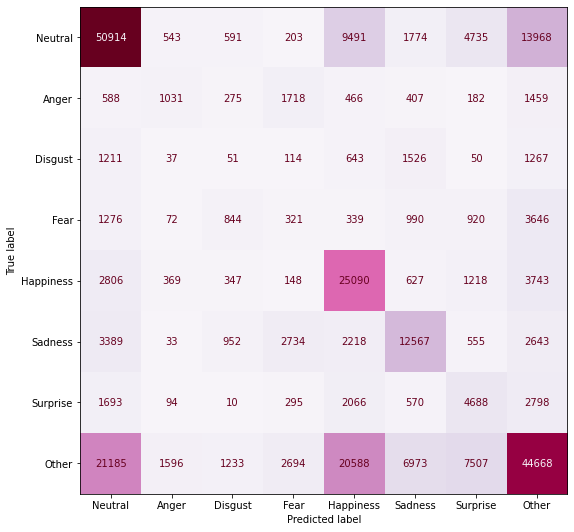

In [45]:
labels=classes
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})

plt_conf_matrix(np.array(labels_val),np.array(pred_labels_val),labels);

In [46]:
torch.save(model.state_dict(), 'simplemodel.pt')

experiment.log_model("simplemodel.pt", file_or_folder="simplemodel.pt")
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/96889028072e483c961dcc3c9bc7e010
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     f1_train [10]   : (0.7077684206374223, 0.9233179570662118)
COMET INFO:     f1_val [10]     : (0.29624292018137566, 0.3414056361769212)
COMET INFO:     loss [2293]     : (1.2899404764175415, 2.0801503658294678)
COMET INFO:     loss_train [10] : (2.32917645974101, 2.4810899855474737)
COMET INFO:     loss_val [10]   : (1.9461395740509033, 1.979109287261963)
COMET INFO:   Others:
COMET INFO:     Name : all_fea-expr_classif
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix    : 1
COMET INFO:     environment details : 1
COMET

In [47]:
results

,f1-score val
only video,0.319133
videoopenl3,0.318535
videow2v2hub,0.326093
videow2v2large,0.326296
videoopensmile,0.00535724
all_fea,0.335656
